In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'models'))
if module_path not in sys.path:
    sys.path.append(module_path)

from NCF_model import NCF, NCFDataset

In [143]:
def custom_collate_fn(batch):
    users, items, emotions, review_embeddings, ratings = zip(*batch)
    
    users = torch.tensor(users, dtype=torch.long)
    items = torch.tensor(items, dtype=torch.long)
    emotions = torch.tensor(emotions, dtype=torch.long)
    review_embeddings = torch.tensor(review_embeddings, dtype=torch.float)
    ratings = torch.tensor(ratings, dtype=torch.float)
    
    # Move tensors to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    users = users.to(device)
    items = items.to(device)
    emotions = emotions.to(device)
    review_embeddings = review_embeddings.to(device)
    ratings = ratings.to(device)
    
    return users, items, emotions, review_embeddings, ratings

In [144]:
embedding_dim = 32
review_embedding_dim = 100
learning_rate = 0.001
batch_size = 64
num_epochs = 10
# Based on the dataset
num_users = 575887
num_items = 74298
num_emotions = 6

test_dataset = torch.load('../data/test_dataset.pth')
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)

In [145]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, num_emotions, review_embedding_dim, 
                 embedding_dim=64, mlp_dims=[256, 128, 64], dropout=0.2):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.user_embedding_mf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mf = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)
        self.emotion_embedding = nn.Embedding(num_emotions, embedding_dim)
        
        # Personalized Emotional Weighting
        self.emotion_weight = nn.Parameter(torch.ones(num_users, 1))
        
        # MF layer
        self.mf_output = embedding_dim
        
        # MLP layers
        self.mlp = nn.ModuleList()
        input_dim = embedding_dim * 3 + review_embedding_dim  # user + item + emotion + review
        mlp_dims = [input_dim] + mlp_dims
        for i in range(len(mlp_dims) - 1):
            self.mlp.append(nn.Linear(mlp_dims[i], mlp_dims[i+1]))
            self.mlp.append(nn.ReLU())
            self.mlp.append(nn.BatchNorm1d(mlp_dims[i+1]))
            self.mlp.append(nn.Dropout(dropout))
        
        # Final prediction layer
        self.final = nn.Linear(self.mf_output + mlp_dims[-1], 1)
        
    def forward(self, user_indices, item_indices, emotion_indices, review_embeddings):
        # MF component
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        
        # MLP component
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        emotion_embedding = self.emotion_embedding(emotion_indices)
        
        # Personalized Emotional Weighting
        emotion_weight = self.emotion_weight[user_indices]
        weighted_emotion_embedding = emotion_embedding * emotion_weight.unsqueeze(1)
        weighted_emotion_embedding = weighted_emotion_embedding.mean(dim=1)
        
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp, weighted_emotion_embedding, review_embeddings], dim=-1)
        
        for layer in self.mlp:
            mlp_vector = layer(mlp_vector)
        
        # Combine MF and MLP
        combined = torch.cat([mf_vector, mlp_vector], dim=-1)
        
        # Final prediction
        prediction = self.final(combined)
        
        return prediction.squeeze()

    def loss(self, prediction, target, gamma=2.0):
        loss = F.mse_loss(prediction, target, reduction='none')
        pt = torch.exp(-loss)  # Probability of the prediction
        focal_loss = ((1 - pt) ** gamma) * loss
        return focal_loss.mean()

In [146]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCF(num_users, num_items, num_emotions, 
            embedding_dim=32, 
            review_embedding_dim=100, 
            mlp_dims=[256, 128, 64], 
            dropout=0.2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [147]:
# Load the best model checkpoint
class ModelLoader:
    def __init__(self, model, checkpoint_path, device):
        self.model = model
        self.checkpoint_path = checkpoint_path
        self.device = device

    def load_best_model(self):
        # Load the checkpoint
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
        print(checkpoint.keys())
        # Check if the checkpoint contains a 'model_state_dict' key
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
        
        # Load the state dictionary into the model
        self.model.load_state_dict(state_dict)
        return self.model


# Example usage
checkpoint_path = '../models/NCF_model_0.3.pth'
model_loader = ModelLoader(model, checkpoint_path, device)
model = model_loader.load_best_model()

dict_keys(['model_state_dict', 'model_architecture'])


In [148]:
from collections import defaultdict

model.eval()
top_k = 10
test_loss = 0.0

# To store top 10 recommendations per user
all_recommendations = defaultdict(list)
emotion_recommendations = defaultdict(list)
actual_items = defaultdict(list)
true_relevance = defaultdict(dict)
true_emotion_relevance = defaultdict(dict)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

with torch.no_grad():
    for user, item, emotion, review_emb, rating in test_loader:
        # Generate predictions for all items for each user
        predictions = model(user, item, emotion, review_emb)
        predictions = predictions.cpu().numpy()

        # Apply softmax to spread out the scores
        predictions = softmax(predictions)

        for i in range(len(predictions)):
            if predictions[i] < 0:
                predictions[i] = 0
            elif predictions[i] > 1:
                predictions[i] = 1
        for u, i, e, p, r in zip(user.numpy(), item.numpy(), emotion.numpy(), predictions, rating.numpy()):
            all_recommendations[u].append((i, p))
            emotion_recommendations[u].append((i, p, e))
            true_relevance[u][i] = r
            true_emotion_relevance[u][i] = (r, e)


In [149]:
min_recommendations = 10
for user, recommendations in all_recommendations.items():
    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    top_k_items = [item for item, _ in sorted_recommendations[:max(top_k, min_recommendations)]]

In [150]:
user_interaction_counts = {user: len(items) for user, items in true_relevance.items()}
print("Average interactions per user:", sum(user_interaction_counts.values()) / len(user_interaction_counts))
print("Min interactions:", min(user_interaction_counts.values()))
print("Max interactions:", max(user_interaction_counts.values()))
print("Number of users:", len(user_interaction_counts))
print("Number of users with less than 10 interactions:", len([count for count in user_interaction_counts.values() if count < 10]))

Average interactions per user: 5.624446571736269
Min interactions: 5
Max interactions: 4991
Number of users: 33428
Number of users with less than 10 interactions: 32562


In [151]:
def dcg_at_k(ranking, relevances, k):
    dcg = 0.0
    for i in range(min(k, len(ranking))):
        item = ranking[i][0]
        relevance = relevances.get(item, 0)
        dcg += (2**relevance - 1) / np.log2(i + 2)
    return dcg

def ndcg_at_k(ranking, relevances, k):
    dcg = dcg_at_k(ranking, relevances, k)
    ideal_ranking = sorted(relevances.items(), key=lambda x: x[1], reverse=True)
    idcg = dcg_at_k(ideal_ranking, relevances, k)
    return dcg / idcg if idcg > 0 else 0

def average_precision(ranking, relevances):
    ap = 0.0
    relevant_count = 0
    num_relevant_items = len(relevances)
    
    if num_relevant_items == 0:
        return 0
    
    for i, (item, _) in enumerate(ranking):
        if relevances.get(item, 0) > 0:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    # Avoid division by zero if there are no relevant items
    return ap / num_relevant_items if num_relevant_items > 0 else 0

# Example usage
k = 10
ndcg_scores = []
ap_scores = []
precisions = []
recalls = []

for user, recommendations in all_recommendations.items():
    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    relevant_items = set(item for item, rating in true_relevance[user].items())
    if len(relevant_items) < 3:  # For users with very few interactions
        top_k_items = [item for item, _ in sorted_recommendations]  # Consider all recommendations
    else:
        top_k_items = [item for item, _ in sorted_recommendations[:k]]
    print(top_k_items)
    true_positives = len(set(top_k_items) & relevant_items)
    precision = true_positives / k
    recall = true_positives / len(relevant_items) if relevant_items else 0
        
    precisions.append(precision)
    recalls.append(recall)
    ndcg = ndcg_at_k(sorted_recommendations, true_relevance[user], k)
    ndcg_scores.append(ndcg)
    ap = average_precision(sorted_recommendations, true_relevance[user])
    ap_scores.append(ap)

print(f"Average Precision@{k}: {np.mean(precisions):.4f}")
print(f"Average Recall@{k}: {np.mean(recalls):.4f}")
mean_ndcg = np.mean(ndcg_scores)
print(f"Mean NDCG@{k}: {mean_ndcg:.4f}")
mean_ap = np.mean(ap_scores)
print(f"Mean Average Precision@{k}: {mean_ap:.4f}")

[54496, 15517, 26960, 6917, 36921, 70609, 25588, 72978, 30631, 32543]
[61751, 32196, 65992, 18251, 70459]
[58830, 0, 27876, 32943, 63118]
[51046, 9569, 22062, 44844, 9681, 60670, 53685, 70892, 9866, 19046]
[9681, 9551, 46954, 34186, 71777, 69753, 3253, 29755, 58518, 45697]
[13635, 34472, 34473, 3, 33580]
[29090, 42017, 38852, 4302, 34864]
[71907, 57239, 36531, 70741, 6452, 73808, 56688, 47358, 9564, 10676]
[71504, 13958, 71503, 13956, 3718, 53617, 58100, 13957]
[30714, 24309, 34472, 36390, 12129, 62900, 4389, 46807, 55506, 27399]
[39373, 73822, 52907, 12, 51539]
[58060, 3326, 69906, 58833, 12400]
[27667, 58364, 3627, 66832, 2640, 52768, 27036, 63957, 12462, 9817]
[51846, 55659, 72263, 38863, 41695]
[59294, 22010, 6577, 34186, 35434]
[41517, 37994, 333, 36294, 59369, 53336, 37229, 510, 34984, 34806]
[17224, 41241, 45354, 7591, 56063]
[69736, 56822, 24, 73305, 47857]
[6460, 9180, 18462, 37404, 30539, 23163, 15865, 25090, 55277, 31310]
[36027, 59943, 13083, 36028, 21249]
[1404, 68789, 400

In [161]:
def evaluate_model_with_emotion(model, test_loader, target_emotion, k=10):
    model.eval()
    all_recommendations = defaultdict(list)
    true_relevance = defaultdict(dict)
    
    with torch.no_grad():
        for user, item, emotion, review_emb, rating in test_loader:
            batch_size = user.size(0)
            
            # Repeat the target emotion for each user in the batch
            target_emotion_tensor = torch.full((batch_size,), target_emotion, dtype=torch.long).to(user.device)
            
            # Generate predictions using the target emotion
            predictions = model(user, item, target_emotion_tensor, review_emb)
            predictions = predictions.cpu().numpy()
            
            # Apply softmax to spread out the scores
            predictions = softmax(predictions)
            
            for u, i, e, p, r in zip(user.numpy(), item.numpy(), emotion.numpy(), predictions, rating.numpy()):
                all_recommendations[u].append((i, p))
                true_relevance[u][i] = r
    
    precisions, recalls, ndcg_scores, ap_scores = [], [], [], []
    
    for user, recommendations in all_recommendations.items():
        sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
        relevant_items = set(true_relevance[user].keys())
        
        if len(relevant_items) < 3:  # For users with very few interactions
            top_k_items = [item for item, _ in sorted_recommendations]  # Consider all recommendations
        else:
            top_k_items = [item for item, _ in sorted_recommendations[:k]]
        
        true_positives = len(set(top_k_items) & relevant_items)
        precision = true_positives / len(top_k_items) if top_k_items else 0
        recall = true_positives / len(relevant_items) if relevant_items else 0
        
        precisions.append(precision)
        recalls.append(recall)
        ndcg = ndcg_at_k(sorted_recommendations, true_relevance[user], k)
        ndcg_scores.append(ndcg)
        ap = average_precision(sorted_recommendations, true_relevance[user])
        ap_scores.append(ap)
    
    return np.mean(precisions), np.mean(recalls), np.mean(ndcg_scores), np.mean(ap_scores)

# Usage
target_emotion = 5  # Replace with the emotion index you want to target
precision, recall, ndcg, map = evaluate_model_with_emotion(model, test_loader, target_emotion, k=10)
print(f"Precision@10 for emotion {target_emotion}: {precision:.4f}")
print(f"Recall@10 for emotion {target_emotion}: {recall:.4f}")
print(f"NDCG@10 for emotion {target_emotion}: {ndcg:.4f}")
print(f"MAP for emotion {target_emotion}: {map:.4f}")

Precision@10 for emotion 5: 1.0000
Recall@10 for emotion 5: 0.9909
NDCG@10 for emotion 5: 0.9639
MAP for emotion 5: 1.0000


In [152]:
true_ratings = []
predicted_ratings = []
for user, recs in all_recommendations.items():
    for item, pred in recs:
        if item in true_relevance[user]:
            true_ratings.append(true_relevance[user][item])
            predicted_ratings.append(pred)

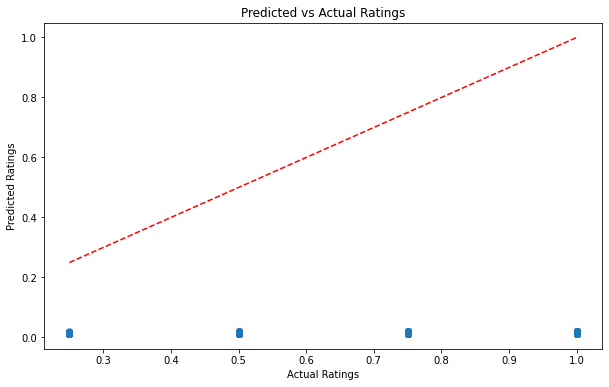

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.scatter(true_ratings, predicted_ratings, alpha=0.5)
plt.plot([min(true_ratings), max(true_ratings)], [min(true_ratings), max(true_ratings)], 'r--')  # Diagonal line for perfect predictions
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

The model might be biased toward predicting high ratings because the majority of the data it sees during training are high ratings. This can lead to a situation where the model struggles to accurately predict lower ratings, which might be less frequent in the dataset.

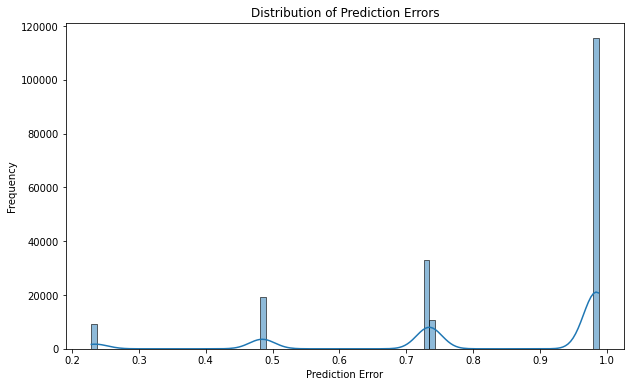

In [154]:
errors = np.array(true_ratings) - np.array(predicted_ratings)
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

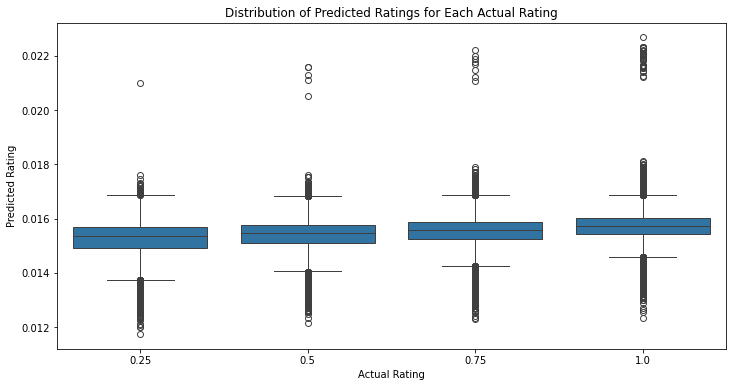

In [155]:
df = pd.DataFrame({'Actual': true_ratings, 'Predicted': predicted_ratings})
plt.figure(figsize=(12, 6))
sns.boxplot(x='Actual', y='Predicted', data=df)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Distribution of Predicted Ratings for Each Actual Rating')
plt.show()

In [156]:
df = pd.DataFrame({'Actual': true_ratings, 'Predicted': predicted_ratings})
df['Predicted'] = pd.cut(df['Predicted'], bins=np.arange(df['Actual'].min(), df['Actual'].max()+1.1, 1))
conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Heatmap of Actual vs Predicted Ratings')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 720x576 with 0 Axes>

In [ ]:
# Count the number of overlaps
overlap_counts = []
for user in all_recommendations.keys():
    recommended_items = set(item for item, _ in all_recommendations[user])
    true_items = set(true_relevance[user].keys())
    overlap = len(recommended_items.intersection(true_items))
    overlap_counts.append(overlap)

<ipython-input-140-0d07596e7190>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Overlap Count', palette='viridis')


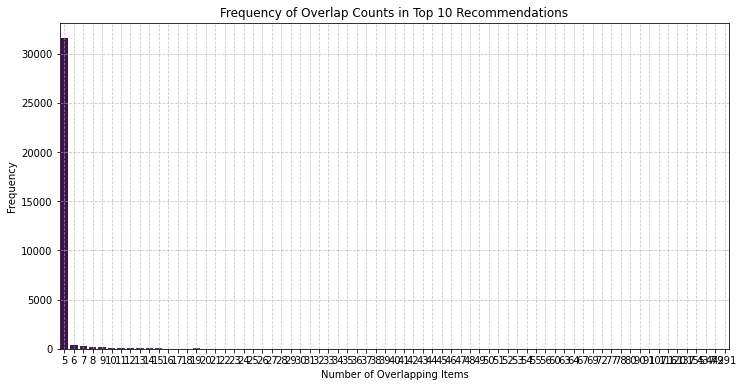

In [ ]:
# Convert overlap_counts to DataFrame
df = pd.DataFrame({'Overlap Count': overlap_counts})

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Overlap Count', palette='viridis')
plt.title('Frequency of Overlap Counts in Top 10 Recommendations')
plt.xlabel('Number of Overlapping Items')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Overall conclusions:

Amazon's recommendation system generally provides diverse suggestions, with little overlap between different users' top 10 lists.
There's a strong tendency towards minimal overlap, supporting the idea that the algorithm aims to personalize recommendations.
The rare cases of high overlap might represent niche categories or highly popular books that appear frequently across different recommendations.
The system balances personalization (low overlap) with some consistency (occasional high overlap), possibly to cater to both individual preferences and popular trends.

Recalibrate the Model:

You might want to consider techniques like scaling the ratings, applying a different loss function (e.g., focusing more on the lower ratings), or using methods like label smoothing to encourage the model to be less confident about assigning the highest rating.

Adjust for Imbalance:

Consider balancing the dataset by oversampling lower ratings or undersampling higher ratings during training. Alternatively, you could apply a weighted loss function that penalizes incorrect predictions more heavily for lower ratings, which are underrepresented.

Emotion-Based Filtering:

If you have specific business logic that, for instance, certain emotions should lead to specific types of recommendations (e.g., a user in a "sad" emotional state might prefer different types of items than when they are in a "joyful" state), you could introduce additional filtering or ranking logic based on the predicted emotions.

Personalized Emotional Weighting:

You might consider giving different weights to the influence of emotions on the final prediction. For example, if you find that emotion is particularly important for certain users or items, you could modify the model or post-process the predictions accordingly.

Tuning Strategies:

1) Add label smoothing or different loss function for the model training
2) Add emotion weights in the model 
3) Introduce a weighting mechanism in the loss function that increases or decreases the penalty for errors based on the emotional state. 
4) Concatenate the emotion embeddings with user and item embeddings at multiple points within the MLP and MF components.